In [2]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
from decimal import Decimal #小数点桁落ちをなくすためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール

In [3]:
#Google colab用
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#GPUを使うためのコマンド
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
#よく使うgit command

#google colabと揃える
#git fetch origin main
#git reset --hard origin/main

In [6]:
#定数を定義
BINS = 100  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合

In [7]:
#Hascの加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[1]))
            AccY.append(float(row[2]))
            AccZ.append(float(row[3]))

    return AccX, AccY, AccZ

In [8]:
#3軸合成加速度を計算する関数
def acc_to_resultant(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める
    return ResultantAcc

In [10]:
#静止区間を除去する関数(STATIONARY_INTERVALS分のみ)
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [13]:
#静止区間を除去する関数(STATIONARY_INTERVALS以上続いた静止区間全て)
def acc_to_remove_all_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
        else:
            if counter >= STATIONARY_INTERVALS:
                del ResultantAcc[i+1-counter:i+1]   #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
            else :
                counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [14]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(Decimal(ResultantAcc[i + 1]) - Decimal(ResultantAcc[i])) for i in range(len(ResultantAcc) - 1)]  #連続する2サンプルの誤差を取る
    return DifferenceAcc

In [15]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, density=True) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [16]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [17]:
#path名から標準化されたヒストグラムと正解ラベルを返す関数
def path_to_histogram(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    #静止区間を除去
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram(DifferenceAcc_list)

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    return DifferenceAcc_hist, Hz

In [ ]:
#path名から標準化された様々な特徴量と正解ラベルを返す関数
def path_to_features(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    features = np.ones((len(Hz), 6))    #各特徴量を入れる変数でこの関数の返り値

    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_resultant(AccX[i], AccY[i], AccZ[i]))
        features[i][0] = np.var(ResultantAcc[i])   #静止区間を除去する前の合成加速度の分散値を0列目に格納

    #静止区間を除去
    ResultantAcc = []
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    for i in range(len(Hz)):
      features[i][1] = np.var(ResultantAcc[i])   #静止区間を除去した後の合成加速度の分散値を11列目に格納

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)


    for i in range(len(Hz)):
      features[i][2] = kurtosis(DifferenceAcc_hist[i])
      features[i][3] = skew(DifferenceAcc_hist[i])

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    for i in range(len(Hz)):
      features[i][4] = kurtosis(DifferenceAcc_hist[i])
      features[i][5] = skew(DifferenceAcc_hist[i])

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(features)
    # Use the scaler to transform x_train and x_test
    features = scaler.transform(features)

    return features, Hz

In [90]:
pathHasc = "/content/drive/MyDrive/hasc(walk)/"
filename = os.listdir(pathHasc) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [91]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHasc+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHasc = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHasc = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHasc)

#静止区間を除去
for i in range(len(HzHasc)):
    ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))


#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHasc = create_histogram(DifferenceAcc_list)

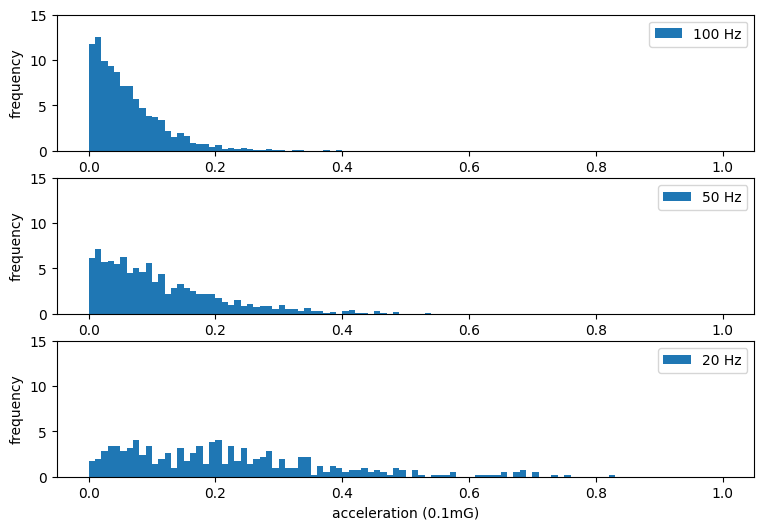

In [26]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [27]:
pathHascJog = "/content/drive/MyDrive/hasc(jog)/"
filename = os.listdir(pathHascJog) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [29]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHascJog+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHascJog = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHascJog = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHascJog)

#静止区間を除去
for i in range(len(HzHascJog)):
    ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHascJog = create_histogram(DifferenceAcc_list)

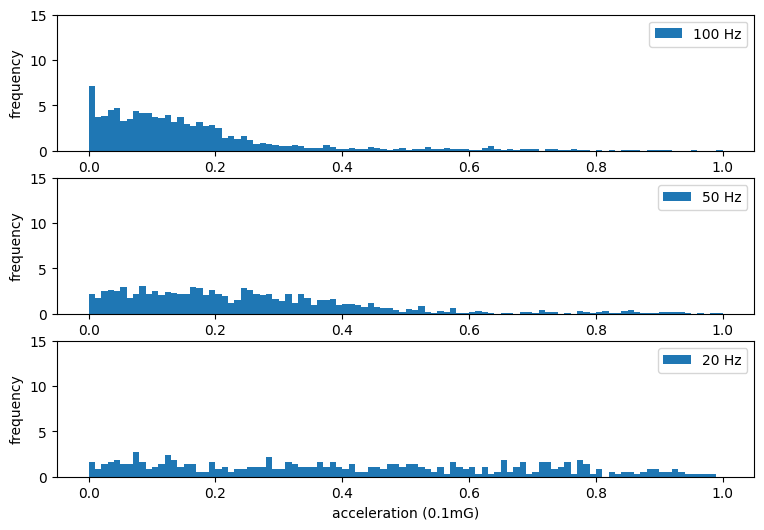

In [30]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_histHasc,  HzHasc, test_size = 0.2, random_state=123)

In [92]:
#標準化
scaler = StandardScaler()
# Fit the scaler to x_train
scaler.fit(DifferenceAcc_histHasc)
# Use the scaler to transform x_train and x_test
DifferenceAcc_histHasc = scaler.transform(DifferenceAcc_histHasc)

In [101]:
mae=[]
from tensorflow import keras

In [103]:
model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.mean_squared_error,
      metrics=[keras.metrics.mean_squared_error],
  )
history = model.fit(X_train, y_train, batch_size=32, epochs=300, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, y_test))
mae

Epoch 1/300
10/10 [==============================] - 5s 61ms/step - loss: 55.0458 - mean_squared_error: 55.0458 - val_loss: 173.3733 - val_mean_squared_error: 173.3734
Epoch 2/300
10/10 [==============================] - 0s 16ms/step - loss: 62.0997 - mean_squared_error: 62.0997 - val_loss: 176.7575 - val_mean_squared_error: 176.7575
Epoch 3/300
10/10 [==============================] - 0s 15ms/step - loss: 56.3718 - mean_squared_error: 56.3718 - val_loss: 170.9135 - val_mean_squared_error: 170.9135
Epoch 4/300
10/10 [==============================] - 0s 17ms/step - loss: 44.1913 - mean_squared_error: 44.1913 - val_loss: 183.1883 - val_mean_squared_error: 183.1883
Epoch 5/300
10/10 [==============================] - 0s 17ms/step - loss: 57.0257 - mean_squared_error: 57.0257 - val_loss: 179.8757 - val_mean_squared_error: 179.8757
Epoch 6/300
10/10 [==============================] - 0s 16ms/step - loss: 40.2771 - mean_squared_error: 40.2771 - val_loss: 196.2540 - val_mean_squared_error: 1

[12.212765957446809, 12.680851063829786]

In [63]:
#HascWalkで構築→HascJogで試す
for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_histHasc, HzHasc, test_size = 0.2)
  model.reset_states()
  # Compile the model
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.mean_squared_error,
      metrics=[keras.metrics.mean_squared_error],
  )
  history = model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.2)
  y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
  mae.append(mean_absolute_error(y_pred, y_test))

mae

Epoch 1/50
10/10 [==============================] - 5s 38ms/step - loss: 60.6872 - mean_squared_error: 60.6872 - val_loss: 16.0619 - val_mean_squared_error: 16.0619
Epoch 2/50
10/10 [==============================] - 0s 14ms/step - loss: 62.5205 - mean_squared_error: 62.5205 - val_loss: 6.4031 - val_mean_squared_error: 6.4031
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 45.9750 - mean_squared_error: 45.9750 - val_loss: 5.1043 - val_mean_squared_error: 5.1043
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 58.9190 - mean_squared_error: 58.9190 - val_loss: 6.5956 - val_mean_squared_error: 6.5956
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 47.7297 - mean_squared_error: 47.7297 - val_loss: 4.5319 - val_mean_squared_error: 4.5319
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 47.0553 - mean_squared_error: 47.0553 - val_loss: 8.1144 - val_mean_squared_error: 8.1144
Epoch 7/50
10/10 [==

[2.276595744680851,
 1.872340425531915,
 2.1914893617021276,
 2.723404255319149,
 1.8085106382978724]

In [ ]:
#標準化
scaler = StandardScaler()
# Fit the scaler to x_train
scaler.fit(DifferenceAcc_histHasc)
# Use the scaler to transform x_train and x_test
DifferenceAcc_histHasc = scaler.transform(DifferenceAcc_histHasc)

In [ ]:
#標準化
scaler = StandardScaler()
# Fit the scaler to x_train
scaler.fit(DifferenceAcc_histHascJog)
# Use the scaler to transform x_train and x_test
DifferenceAcc_histHascJog = scaler.transform(DifferenceAcc_histHascJog)

In [ ]:
HistHascWalk, HzHascWalk = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [ ]:
hw21, kw17, kr14, hj19

In [ ]:
FeaturesHascWalk, HzHascWalk = path_to_features("/content/drive/MyDrive/hasc(jog)/")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(HHascWalk, HzHascWalk, test_size = 0.2, random_state=123)

In [ ]:
# パラメータ（alpha）を探索するモジュール
from sklearn.linear_model import RidgeCV

# パラメータ（alpha）をプロットするモジュール
from yellowbrick.regressor import AlphaSelection

# Ridge 回帰を実行するモジュール（最小二乗法＋L2正則化項）
from sklearn.linear_model import Ridge

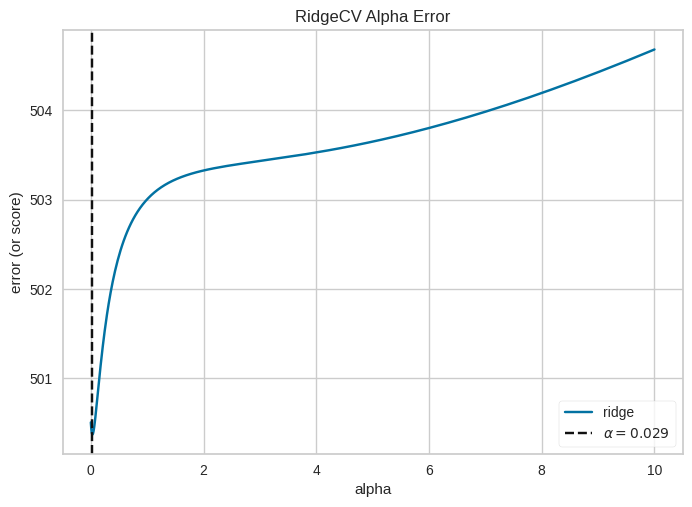

In [ ]:
# パラメータ（alpha）の探索区間を設定
alphas = np.logspace(-10, 1, 500)

# 訓練データを交差検証し、最適な alpha を求める
ridgeCV = RidgeCV(alphas = alphas)

# alpha をプロットする
visualizer = AlphaSelection(ridgeCV)
visualizer.fit(X_train, y_train)

visualizer.show()
plt.show()

In [ ]:
# Ridge回帰のインスタンスを作成
ridge = Ridge(alpha = 0.029)

# 訓練データからモデルを生成（最小二乗法＋正則化項）
ridge.fit(X_train, y_train)

# 切片を出力
print(ridge.intercept_)

# 回帰係数（傾き）を出力
print(ridge.coef_)

59.55593273946129
[-70.00318639  69.19725342  -8.46622055  20.76097762  -8.40248656
   7.15504689]


In [ ]:
y_pred = tf.cast(tf.clip_by_value(ridge.predict(X_test), 20, 100), tf.int32)

In [ ]:
mean_absolute_error(y_pred, y_test)

19.26595744680851

In [ ]:
# 訓練データに対するスコア
print(ridge.score(X_train, y_train))

# テストデータに対するスコア
print(ridge.score(X_test, y_test))

In [ ]:
HistHascJog, HzHascJog = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [ ]:
HistHascSkip, HzHascSkip = path_to_histogram("/content/drive/MyDrive/hasc(skip)/")

In [ ]:
HistHascSequence, HzHascSequence = path_to_histogram("/content/drive/MyDrive/hasc(sequence)/")

In [94]:
#transformer regression
#各種パラメータ
NUM_HEADS = 2
KEY_DIM = 50
BINS = 100
DROPOUT = 0.1
N = 1

# Define the input shape
input_shape = (BINS,)
output_shape = (1,)

#形を定義(このモジュールは行列でないとダメっぽい)
inputs_encoder = layers.Input(shape=input_shape)
inputs_decoder = layers.Input(shape=output_shape)

In [95]:
#Encoderに対する入力の形状
x_encoder = layers.Reshape((1, 100))(inputs_encoder)

In [96]:
#Transformer Encoder Layer(BERT)
for i in range(N):
      #Multi-Head-Attention Layer
      attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

      #Dropout Layer
      attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
      #Add & Norm Layer
      attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

      #Feed-Forward-Network
      ffn_encoder = layers.Dense(BINS * 4, use_bias=True, activation="relu")(attention_encoder)
      ffn_encoder = layers.Dense(BINS, use_bias=True)(ffn_encoder)

      #Dropout Layer
      ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
      #Add & Norm Layer
      x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

In [97]:
x = layers.Flatten()(x_encoder)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="relu")(x)

In [98]:
model = keras.Model(inputs=inputs_encoder, outputs=outputs)

In [99]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error],
)

In [38]:
mae = []
mse = []
r2 = []

In [39]:
EPOCHS = 100

In [ ]:
HistHascWalk, HzHascWalk = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [ ]:
HistHascJog, HzHascJog = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [ ]:
HistKuharWalk, HzKuharWalk = path_to_histogram("/content/drive/MyDrive/kuhar(walk)/")

In [ ]:
HistKuharRun, HzKuharRun = path_to_histogram("/content/drive/MyDrive/kuhar(run)/")

In [ ]:
#HascWalkで構築→HascJogで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
12/12 [==============================] - 0s 14ms/step - loss: 240.0528 - mean_squared_error: 240.0528 - val_loss: 535.8604 - val_mean_squared_error: 535.8604
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 164.1647 - mean_squared_error: 164.1647 - val_loss: 473.7133 - val_mean_squared_error: 473.7133
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 123.8330 - mean_squared_error: 123.8330 - val_loss: 317.2139 - val_mean_squared_error: 317.2139
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 116.5087 - mean_squared_error: 116.5087 - val_loss: 488.9413 - val_mean_squared_error: 488.9413
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 102.8533 - mean_squared_error: 102.8533 - val_loss: 340.1848 - val_mean_squared_error: 340.1848
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 76.2584 - mean_squared_error: 76.2584 - val_loss: 465.7290 - val_mean_squared

In [ ]:
#HascWalkで構築→KuharWalkで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

Epoch 1/100
12/12 [==============================] - 0s 22ms/step - loss: 55.3406 - mean_squared_error: 55.3406 - val_loss: 373.5448 - val_mean_squared_error: 373.5448
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 59.8411 - mean_squared_error: 59.8411 - val_loss: 433.3891 - val_mean_squared_error: 433.3891
Epoch 3/100
12/12 [==============================] - 0s 22ms/step - loss: 50.9372 - mean_squared_error: 50.9372 - val_loss: 385.8459 - val_mean_squared_error: 385.8459
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 57.3609 - mean_squared_error: 57.3609 - val_loss: 435.7101 - val_mean_squared_error: 435.7101
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 48.2881 - mean_squared_error: 48.2881 - val_loss: 432.2419 - val_mean_squared_error: 432.2419
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 66.0908 - mean_squared_error: 66.0908 - val_loss: 452.9612 - val_mean_squared_error: 4

In [ ]:
#HascWalkで構築→KuharRunで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

Epoch 1/100
12/12 [==============================] - 0s 14ms/step - loss: 47.7472 - mean_squared_error: 47.7472 - val_loss: 449.4026 - val_mean_squared_error: 449.4026
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 55.3455 - mean_squared_error: 55.3455 - val_loss: 429.0188 - val_mean_squared_error: 429.0188
Epoch 3/100
12/12 [==============================] - 0s 14ms/step - loss: 52.0354 - mean_squared_error: 52.0354 - val_loss: 459.4611 - val_mean_squared_error: 459.4611
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 57.5264 - mean_squared_error: 57.5264 - val_loss: 379.3170 - val_mean_squared_error: 379.3170
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 50.1761 - mean_squared_error: 50.1761 - val_loss: 463.5359 - val_mean_squared_error: 463.5359
Epoch 6/100
12/12 [==============================] - 0s 14ms/step - loss: 52.3174 - mean_squared_error: 52.3174 - val_loss: 404.2613 - val_mean_squared_error: 4

In [ ]:
#HascJogで構築→HascWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
12/12 [==============================] - 0s 13ms/step - loss: 273.6608 - mean_squared_error: 273.6608 - val_loss: 349.0771 - val_mean_squared_error: 349.0771
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 183.5441 - mean_squared_error: 183.5441 - val_loss: 366.8683 - val_mean_squared_error: 366.8683
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 114.3814 - mean_squared_error: 114.3814 - val_loss: 414.9211 - val_mean_squared_error: 414.9211
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 106.6274 - mean_squared_error: 106.6274 - val_loss: 265.8859 - val_mean_squared_error: 265.8859
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 112.0286 - mean_squared_error: 112.0286 - val_loss: 351.6499 - val_mean_squared_error: 351.6499
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 104.8993 - mean_squared_error: 104.8993 - val_loss: 339.6613 - val_mean_squar

In [ ]:
#HascJogで構築→KuharWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

Epoch 1/100
12/12 [==============================] - 0s 13ms/step - loss: 45.9765 - mean_squared_error: 45.9765 - val_loss: 316.3569 - val_mean_squared_error: 316.3569
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 45.7524 - mean_squared_error: 45.7524 - val_loss: 330.5042 - val_mean_squared_error: 330.5042
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 50.5863 - mean_squared_error: 50.5863 - val_loss: 379.2931 - val_mean_squared_error: 379.2931
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 60.6297 - mean_squared_error: 60.6297 - val_loss: 301.3892 - val_mean_squared_error: 301.3892
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 49.5765 - mean_squared_error: 49.5765 - val_loss: 344.1815 - val_mean_squared_error: 344.1815
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 48.3220 - mean_squared_error: 48.3220 - val_loss: 327.2834 - val_mean_squared_error: 327

In [ ]:
#HascJogで構築→KuharRunで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

Epoch 1/100
12/12 [==============================] - 0s 18ms/step - loss: 46.7646 - mean_squared_error: 46.7646 - val_loss: 336.0366 - val_mean_squared_error: 336.0366
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 44.4569 - mean_squared_error: 44.4569 - val_loss: 356.3748 - val_mean_squared_error: 356.3748
Epoch 3/100
12/12 [==============================] - 0s 14ms/step - loss: 60.7946 - mean_squared_error: 60.7946 - val_loss: 373.5944 - val_mean_squared_error: 373.5944
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 51.5351 - mean_squared_error: 51.5351 - val_loss: 334.2382 - val_mean_squared_error: 334.2382
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 47.9246 - mean_squared_error: 47.9246 - val_loss: 355.1764 - val_mean_squared_error: 355.1764
Epoch 6/100
12/12 [==============================] - 0s 15ms/step - loss: 51.7757 - mean_squared_error: 51.7757 - val_loss: 336.2226 - val_mean_squared_error: 3

In [ ]:
#KuharWalkで構築→HascWalkで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
43/43 [==============================] - 1s 12ms/step - loss: 125.5226 - mean_squared_error: 125.5226 - val_loss: 314.0888 - val_mean_squared_error: 314.0888
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 83.9608 - mean_squared_error: 83.9608 - val_loss: 269.0991 - val_mean_squared_error: 269.0991
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 74.2983 - mean_squared_error: 74.2983 - val_loss: 232.2768 - val_mean_squared_error: 232.2768
Epoch 4/100
43/43 [==============================] - 0s 8ms/step - loss: 69.2995 - mean_squared_error: 69.2995 - val_loss: 283.8161 - val_mean_squared_error: 283.8161
Epoch 5/100
43/43 [==============================] - 0s 9ms/step - loss: 63.1740 - mean_squared_error: 63.1740 - val_loss: 308.8419 - val_mean_squared_error: 308.8419
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 63.8036 - mean_squared_error: 63.8036 - val_loss: 270.5540 - val_mean_squared_error: 270.

In [ ]:
#KuharWalkで構築→HascJogで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
43/43 [==============================] - 0s 9ms/step - loss: 48.2412 - mean_squared_error: 48.2412 - val_loss: 355.5357 - val_mean_squared_error: 355.5357
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 50.5460 - mean_squared_error: 50.5460 - val_loss: 272.7482 - val_mean_squared_error: 272.7482
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 49.5853 - mean_squared_error: 49.5853 - val_loss: 288.6144 - val_mean_squared_error: 288.6144
Epoch 4/100
43/43 [==============================] - 0s 8ms/step - loss: 50.3938 - mean_squared_error: 50.3938 - val_loss: 279.5338 - val_mean_squared_error: 279.5338
Epoch 5/100
43/43 [==============================] - 0s 8ms/step - loss: 50.5639 - mean_squared_error: 50.5639 - val_loss: 298.4003 - val_mean_squared_error: 298.4003
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 49.1328 - mean_squared_error: 49.1328 - val_loss: 313.0439 - val_mean_squared_error: 313.043

In [ ]:
#KuharWalkで構築→KuharRunで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

Epoch 1/100
43/43 [==============================] - 0s 8ms/step - loss: 42.8771 - mean_squared_error: 42.8771 - val_loss: 282.8653 - val_mean_squared_error: 282.8653
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 46.8448 - mean_squared_error: 46.8448 - val_loss: 274.9104 - val_mean_squared_error: 274.9104
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 39.1084 - mean_squared_error: 39.1084 - val_loss: 296.3801 - val_mean_squared_error: 296.3801
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 46.6385 - mean_squared_error: 46.6385 - val_loss: 281.7991 - val_mean_squared_error: 281.7991
Epoch 5/100
43/43 [==============================] - 0s 8ms/step - loss: 42.0720 - mean_squared_error: 42.0720 - val_loss: 316.9504 - val_mean_squared_error: 316.9504
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 44.4491 - mean_squared_error: 44.4491 - val_loss: 310.9637 - val_mean_squared_error: 310.963

In [ ]:
#KuharRunで構築→HascWalkで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

Epoch 1/100
33/33 [==============================] - 0s 9ms/step - loss: 246.2962 - mean_squared_error: 246.2962 - val_loss: 456.1268 - val_mean_squared_error: 456.1268
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 181.7850 - mean_squared_error: 181.7850 - val_loss: 470.3372 - val_mean_squared_error: 470.3372
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 149.3447 - mean_squared_error: 149.3447 - val_loss: 521.1007 - val_mean_squared_error: 521.1007
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 139.5534 - mean_squared_error: 139.5534 - val_loss: 442.0963 - val_mean_squared_error: 442.0963
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 124.2549 - mean_squared_error: 124.2549 - val_loss: 436.1020 - val_mean_squared_error: 436.1020
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 107.3077 - mean_squared_error: 107.3077 - val_loss: 388.7790 - val_mean_squared_er

In [ ]:
#KuharRunで構築→HascJogで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

Epoch 1/100
33/33 [==============================] - 0s 10ms/step - loss: 59.1508 - mean_squared_error: 59.1508 - val_loss: 390.6214 - val_mean_squared_error: 390.6214
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 56.9096 - mean_squared_error: 56.9096 - val_loss: 452.4979 - val_mean_squared_error: 452.4979
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 52.1062 - mean_squared_error: 52.1062 - val_loss: 432.8189 - val_mean_squared_error: 432.8189
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 50.7190 - mean_squared_error: 50.7190 - val_loss: 466.7183 - val_mean_squared_error: 466.7183
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 54.6388 - mean_squared_error: 54.6388 - val_loss: 406.7464 - val_mean_squared_error: 406.7464
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 57.9296 - mean_squared_error: 57.9296 - val_loss: 459.9494 - val_mean_squared_error: 459.94

In [ ]:
#KuharRunで構築→KuharWalkで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

Epoch 1/100
33/33 [==============================] - 0s 9ms/step - loss: 48.7146 - mean_squared_error: 48.7146 - val_loss: 495.2933 - val_mean_squared_error: 495.2933
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 53.0832 - mean_squared_error: 53.0832 - val_loss: 483.5313 - val_mean_squared_error: 483.5313
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 51.5506 - mean_squared_error: 51.5506 - val_loss: 466.8340 - val_mean_squared_error: 466.8340
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 49.4231 - mean_squared_error: 49.4231 - val_loss: 465.8785 - val_mean_squared_error: 465.8785
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 51.1747 - mean_squared_error: 51.1747 - val_loss: 450.2640 - val_mean_squared_error: 450.2640
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 53.3082 - mean_squared_error: 53.3082 - val_loss: 476.1057 - val_mean_squared_error: 476.1

In [ ]:
mae

[13.929487179487179,
 9.69562647754137,
 17.188736681887367,
 11.297008547008547,
 11.303191489361701,
 15.031963470319635,
 11.286324786324787,
 11.66025641025641,
 14.257229832572298,
 11.664529914529915,
 13.418803418803419,
 11.245862884160756]

In [ ]:
#HascWalkで構築→HascSkipで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

In [ ]:
#HascWalkで構築→HascSequenceで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascJogで構築→HascWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascJogで構築→HascSkipで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

In [ ]:
#HascJogで構築→HascSequenceで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascSkipで構築→HascWalkで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascSkipで構築→HascJogで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#HascSkipで構築→HascSequenceで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascSequenceで構築→HascWalkで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascSequenceで構築→HascJogで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#HascSequenceで構築→HascSkipで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))